## Quantization

In [ ]:
!pip install --upgrade pip
!pip install "numpy<2" --force-reinstall --no-cache-dir
!pip install "torch==2.4.1" "torchvision==0.19.1" "torchao==0.14.1" --force-reinstall --no-cache-dir
!pip install -q tqdm matplotlib pandas torchmetrics

In [1]:
import torch, torchao, numpy as np
import sys
print("Python:", sys.version.splitlines()[0])
print("Torch:", torch.__version__)
print("TorchAO:", torchao.__version__)
print("NumPy:", np.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    dev = torch.cuda.current_device()
    props = torch.cuda.get_device_properties(dev)
    print("CUDA device:", props.name, "capability:", props.major, props.minor, "total mem (GB):", props.total_memory/1024**3)
else:
    print("No CUDA device detected.")


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Torch: 2.6.0+cu124
TorchAO: 0.10.0
NumPy: 1.26.4
CUDA available: True
CUDA device: Tesla T4 capability: 7 5 total mem (GB): 14.74127197265625


In [60]:
import os, copy, time, math
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import torch.nn.functional as F
from collections import defaultdict

import torchao
from torchao.quantization import quantize_, Int8WeightOnlyConfig, Int4WeightOnlyConfig
from torchao.dtypes import Int4CPULayout
import torch.ao.quantization as taq
from torch.ao.quantization import get_default_qconfig
from torch.ao.quantization import prepare_qat, convert, QConfig
from torch.ao.quantization import  MinMaxObserver, FakeQuantize, QConfigMapping
from torch.ao.quantization.quantize_fx import prepare_qat_fx, convert_fx
from torchao.quantization import (
    int8_dynamic_activation_int8_weight,   
    quantize_                              
)



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def print_size(bytes_val):
    for u in ['B','KB','MB','GB']:
        if bytes_val < 1024.0:
            return f"{bytes_val:3.2f}{u}"
        bytes_val /= 1024.0
    return f"{bytes_val:.2f}TB"

def model_file_size(path):
   
    if os.path.exists(path):
        size_bytes = os.path.getsize(path)
        size_mb = size_bytes / 1e6 
        return round(size_mb, 2)
    else:
        return 0.0

def measure_latency(model, device, input_shape=(1,3,32,32), runs=40, warmup=10):
    model.eval()
    x = torch.randn(input_shape).to(device)
    # warmup
    if device.type == 'cuda':
        torch.cuda.synchronize()
    for _ in range(warmup):
        _ = model(x)
    if device.type == 'cuda':
        torch.cuda.synchronize()
    t0 = time.time()
    for _ in range(runs):
        _ = model(x)
        if device.type == 'cuda':
            torch.cuda.synchronize()
    return (time.time() - t0)/runs



### Data: CIFAR-100 loaders

In [80]:
batch_size = 128
num_workers = 2
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071,0.4867,0.4408),(0.2675,0.2565,0.2761))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071,0.4867,0.4408),(0.2675,0.2565,0.2761))
])

trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset  = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=batch_size, shuffle=False, num_workers=num_workers)

print("Train size:", len(trainset), "Test size:", len(testset))

Train size: 50000 Test size: 10000


### Model: VGG-11 builder + evaluate function

In [77]:
def make_vgg11(num_classes=100):
    m = models.vgg11(pretrained=False)
    m.classifier[6] = nn.Linear(m.classifier[6].in_features, num_classes)
    return m

def evaluate(model, loader, device):
    model.eval()
    device = next(model.parameters()).device if any(True for _ in model.parameters()) else device
    total, correct = 0, 0
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            _,pred = out.max(1)
            total += y.size(0); correct += (pred==y).sum().item()
    return 100.*correct/total

baseline = make_vgg11()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
baseline = baseline.to(device)
print("Baseline device:", device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Baseline device: cuda


### baseline training

In [27]:
ckpt_path = "/kaggle/working/vgg11_baseline.pth"
if os.path.exists(ckpt_path):
    baseline.load_state_dict(torch.load(ckpt_path, map_location=device))
    print("Loaded baseline checkpoint.")
else:
    opt = optim.SGD(baseline.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()
    epochs = 50
    for ep in range(epochs):
        baseline.train()
        pbar = tqdm(trainloader, desc=f"Train ep{ep+1}")
        for x,y in pbar:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            out = baseline(x)
            loss = loss_fn(out, y)
            loss.backward()
            opt.step()
        test_acc = evaluate(baseline, testloader, device)
        print(f"Epoch {ep+1} test acc: {test_acc:.2f}")
    torch.save(baseline.state_dict(), ckpt_path)
    print("Saved baseline:", ckpt_path)

Loaded baseline checkpoint.


### PTQ (FP16, BF16, INT8, INT4) — using torchao

In [28]:
results = []

# FP32 baseline
baseline.eval()
with torch.no_grad():
    baseline_acc = evaluate(baseline, testloader, device) 
torch.save(baseline.state_dict(), "vgg11_fp32.pth")
results.append({'dtype':'fp32','acc': baseline_acc, 'size_bytes(MB)': model_file_size("vgg11_fp32.pth"), 'device': str(device)})

# FP16
model_fp16 = copy.deepcopy(baseline).to(device).half()  
model_fp16.eval()

fp16_acc = 0.0
correct, total = 0, 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device).half(), labels.to(device)
        outputs = model_fp16(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
fp16_acc = 100. * correct / total

torch.save(model_fp16.state_dict(), "vgg11_fp16.pth")
results.append({'dtype':'fp16','acc':fp16_acc,'size_bytes(MB)':model_file_size("vgg11_fp16.pth"),'device':str(device)})
print("FP16 acc:", fp16_acc)

# BF16 

bf16_supported = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
if not bf16_supported:
    print(" BF16 not supported natively on this GPU (T4). Will simulate on CPU instead.")

model_bf16 = copy.deepcopy(baseline).to(device).to(torch.bfloat16)
model_bf16.eval()

correct, total = 0, 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        if bf16_supported:
            images = images.to(torch.bfloat16)
        else:
            images = images.to(torch.float32) 
        outputs = model_bf16(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
bf16_acc = 100. * correct / total

torch.save(model_bf16.state_dict(), "vgg11_bf16.pth")
results.append({'dtype':'bf16','acc':bf16_acc,'size_bytes(MB)':model_file_size("vgg11_bf16.pth"),'device':str(device)})
print("BF16 acc:", bf16_acc)


# INT8  with torchao 

model_int8 = copy.deepcopy(baseline)               
int8_cfg = int8_dynamic_activation_int8_weight()  
quantize_(model_int8, int8_cfg)                      

model_int8 = model_int8.to(device)
model_int8.eval()

int8_acc = evaluate(model_int8, testloader, device)
torch.save(model_int8.state_dict(), "vgg11_int8_torchao.pth")

results.append({
    "dtype": "int8",
    "acc":   round(int8_acc, 3),
    "size_bytes(MB)": round(model_file_size("vgg11_int8_torchao.pth"), 2),
    "device": str(device)
})

# INT4 

def quantize_to_int4(tensor: torch.Tensor) -> torch.Tensor:
    if tensor is None:
        return None  
    qmin, qmax = -8, 7  
    scale = tensor.abs().max() / qmax
    if scale == 0:
        return tensor.clone()  
    q_tensor = torch.clamp((tensor / scale).round(), qmin, qmax)
    return (q_tensor * scale).to(torch.float32)

#  int4 quantization for comparison
def apply_simulated_int4_quant(model: nn.Module) -> nn.Module:
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)) and hasattr(m, "weight") and m.weight is not None:
            with torch.no_grad():
                q_weight = quantize_to_int4(m.weight)
                if q_weight is not None:
                    m.weight.copy_(q_weight)
    return model

def theoretical_int4_size_mb(model):
    total_params = sum(p.numel() for p in model.parameters())
    return round(total_params * 4 / 8 / 1e6, 2)   

model_int4 = copy.deepcopy(baseline).cpu()
model_int4 = apply_simulated_int4_quant(model_int4)
int4_acc = evaluate(model_int4, testloader, torch.device('cpu'))

torch.save(model_int4.state_dict(), "vgg11_int4_fake.pth")

# computing theoretical size
total_bits = 0
for name, param in model_int4.named_parameters():
    bits = param.numel() * 4 if param.requires_grad else 0
    total_bits += bits
theoretical_size_mb = round(total_bits / 8 / 1e6, 2)

results.append({
    'dtype': 'int4_simulated',
    'acc': int4_acc,
    'size_bytes(MB)': theoretical_size_mb,
    'device': 'cpu'
})
print("INT4 acc:", int4_acc)

df = pd.DataFrame(results)
display(df)

FP16 acc: 57.96
BF16 acc: 57.92
INT4 acc: 51.55


,dtype,acc,size_bytes(MB),device
0,fp32,57.95,516.71,cuda
1,fp16,57.96,258.36,cuda
2,bf16,57.92,258.36,cuda
3,int8,57.99,156.91,cuda
4,int4_simulated,51.55,64.59,cpu


### QAT (FP16, BF16, INT8, INT4) 

In [29]:
results_qat = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("QAT running on device:", device)

#  Helper functions
def simulate_bfloat16_tensor(t: torch.Tensor) -> torch.Tensor:
    if t.numel() == 0:
        return t
    cpu = t.detach().cpu().numpy().astype(np.float32)
    u = cpu.view(np.uint32)
    u &= 0xFFFF0000  
    out = u.view(np.float32)
    return torch.from_numpy(out).to(t.device)

def finetune_fp16_qat(model, epochs, trainloader, lr=1e-4, device=device):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    for ep in range(epochs):
        model.train()
        pbar = tqdm(trainloader, desc=f"FP16 QAT epoch {ep+1}/{epochs}")
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            with torch.amp.autocast('cuda', dtype=torch.float16):
                out = model(xb)
                loss = loss_fn(out, yb)
            loss.backward()   # no GradScaler to avoid unscale mismatch on T4
            opt.step()
            pbar.set_postfix({'loss': loss.item()})
    return model

def finetune_bf16_qat(model, epochs, trainloader, lr=1e-4, device=device):
    bf16_hw = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    for ep in range(epochs):
        model.train()
        pbar = tqdm(trainloader, desc=f"BF16 QAT epoch {ep+1}/{epochs} (native={bf16_hw})")
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            if bf16_hw:
                with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                    out = model(xb)
                    loss = loss_fn(out, yb)
                loss.backward()
            else:
                         
                xb_sim = simulate_bfloat16_tensor(xb)
                handles = []
                def hook_fn(module, inp, out):
                    return out
               
                out = model(xb_sim)
                loss = loss_fn(out, yb)
                loss.backward()
            opt.step()
            pbar.set_postfix({'loss': loss.item()})
    return model

# INT8 QAT using torch.ao.quantization
def finetune_qat(model, epochs=1, loader=trainloader, lr=1e-4):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()
    model.train()
    for ep in range(epochs):
        pbar = tqdm(loader, desc=f"QAT epoch {ep+1}/{epochs}")
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = crit(out, y)
            loss.backward()
            opt.step()
            pbar.set_postfix(loss=loss.item())
    return model

# INT4 simulated QAT modules 
class QConv2d(nn.Conv2d):
    def forward(self, x):
        w = self.weight
        maxabs = w.abs().amax()
        qmax = 7                     
        scale = maxabs / qmax if maxabs != 0 else 1.0  
        w_q = torch.fake_quantize_per_tensor_affine(
                  w.data, float(scale), 0, -qmax, qmax)

        return F.conv2d(x, w_q, self.bias,
                        self.stride, self.padding,
                        self.dilation, self.groups)

class QLinear(nn.Linear):
    def forward(self, x):
        w = self.weight
        maxabs = w.abs().amax()
        qmax = 7
        scale = maxabs / qmax if maxabs != 0 else 1.0

        w_q = torch.fake_quantize_per_tensor_affine(
                  w.data, float(scale), 0, -qmax, qmax)

        return F.linear(x, w_q, self.bias)

def replace_with_qmodules(model):
    for name, child in list(model.named_children()):
        if isinstance(child, nn.Conv2d):
            qc = QConv2d(child.in_channels, child.out_channels,
                         child.kernel_size,
                         stride=child.stride, padding=child.padding,
                         dilation=child.dilation, groups=child.groups,
                         bias=(child.bias is not None))
            qc.weight = child.weight
            if child.bias is not None:
                qc.bias = child.bias
            setattr(model, name, qc)
        elif isinstance(child, nn.Linear):
            ql = QLinear(child.in_features, child.out_features,
                         bias=(child.bias is not None))
            ql.weight = child.weight
            if child.bias is not None:
                ql.bias = child.bias
            setattr(model, name, ql)
        else:
            replace_with_qmodules(child)
    return model

def finetune_int4_qat_sim(model, epochs=1, trainloader=trainloader, lr=2e-4, device=device):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    for ep in range(epochs):
        model.train()
        pbar = tqdm(trainloader, desc=f"INT4 QAT epoch {ep+1}/{epochs} (sim)")
        for xb, yb in pbar:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            opt.step()
            pbar.set_postfix({'loss': loss.item()})
    return model


# FP16 QAT 
print("\n--FP16 fine-tuning --")
m_fp16 = copy.deepcopy(baseline)
m_fp16 = finetune_fp16_qat(m_fp16, epochs=5, trainloader=trainloader, lr=1e-4, device=device)
acc_fp16 = evaluate(m_fp16.eval().to(device), testloader, device)
torch.save(m_fp16.state_dict(), "vgg11_fp16_qat.pth")
results_qat.append({'dtype':'fp16_qat','acc':acc_fp16,'size_MB':model_file_size("vgg11_fp16_qat.pth"),'device':str(device)})

# BF16 QAT  
print("\n-- BF16 fine-tuning  --")
m_bf16 = copy.deepcopy(baseline)
m_bf16 = finetune_bf16_qat(m_bf16, epochs=5, trainloader=trainloader, lr=1e-4, device=device)
acc_bf16 = evaluate(m_bf16.eval().to(device), testloader, device)
torch.save(m_bf16.state_dict(), "vgg11_bf16_qat.pth")
results_qat.append({'dtype':'bf16_qat','acc':acc_bf16,'size_MB':model_file_size("vgg11_bf16_qat.pth"),'device':str(device)})

# INT8 QAT 

act_fake = FakeQuantize.with_args(
    observer=MinMaxObserver,
    quant_min=-128, quant_max=127,        
    dtype=torch.qint8,                    
    qscheme=torch.per_tensor_affine
)

wgt_fake = FakeQuantize.with_args(
    observer=MinMaxObserver,
    quant_min=-128, quant_max=127,
    dtype=torch.qint8,
    qscheme=torch.per_tensor_affine
)

custom_qconfig = QConfig(activation=act_fake, weight=wgt_fake)
qconfig_mapping = QConfigMapping().set_global(custom_qconfig)

device = torch.device('cuda')

model_fp32 = make_vgg11()
model_fp32.load_state_dict(torch.load("vgg11_fp32.pth", map_location='cpu'))

model_to_quantize = copy.deepcopy(model_fp32).train().to(device)

example_inputs = (torch.randn(1, 3, 32, 32).to(device),)

prepared = prepare_qat_fx(
    model_to_quantize,
    qconfig_mapping,
    example_inputs
)

print("\n--- INT8 QAT (per-tensor qscheme) ---")
prepared = finetune_qat(prepared, epochs=5)

prepared = prepared.eval()
quantized_model = convert_fx(prepared)
quantized_model = quantized_model.to(device)
int8_qat_acc = evaluate(quantized_model, testloader, device)

torch.save(quantized_model.state_dict(), "vgg11_int8_qat.pth")
results_qat.append({'dtype':'int8_qat','acc':int8_qat_acc,'size_MB':model_file_size("vgg11_int8_qat.pth"),'device':str(device)})

# INT4 QAT (simulated)
model_int4_qat = copy.deepcopy(make_vgg11())
model_int4_qat.load_state_dict(torch.load("vgg11_fp32.pth", map_location='cpu'))
model_int4_qat = replace_with_qmodules(model_int4_qat)
model_int4_qat = finetune_int4_qat_sim(model_int4_qat, epochs=5, trainloader=trainloader, lr=2e-4, device=device)
acc_int4 = evaluate(model_int4_qat.eval().to(device), testloader, device)
torch.save(model_int4_qat.state_dict(), "vgg11_int4_qat_sim.pth")
results_qat.append({'dtype':'int4_qat_sim','acc':acc_int4,'size_MB':theoretical_int4_size_mb(model_int4_qat),'device':str(device)})


# QAT results 

df_qat = pd.DataFrame(results_qat)
display(df_qat)

QAT running on device: cuda

--FP16 fine-tuning --


FP16 QAT epoch 5/5: 100%|██████████| 391/391 [00:41<00:00,  9.34it/s, loss=0.239] 



-- BF16 fine-tuning  --


BF16 QAT epoch 5/5 (native=True): 100%|██████████| 391/391 [03:52<00:00,  1.68it/s, loss=0.141] 
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



--- INT8 QAT (per-tensor qscheme) ---


QAT epoch 5/5: 100%|██████████| 391/391 [00:44<00:00,  8.83it/s, loss=0.225]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
INT4 QAT epoch 5/5 (sim): 100%|██████████| 391/391 [00:22<00:00, 17.44it/s, loss=0.683]


,dtype,acc,size_MB,device
0,fp16_qat,60.51,516.71,cuda
1,bf16_qat,60.50,516.71,cuda
2,int8_qat,60.93,516.71,cuda
3,int4_qat_sim,57.25,64.59,cuda


### Scaling Law Analysis

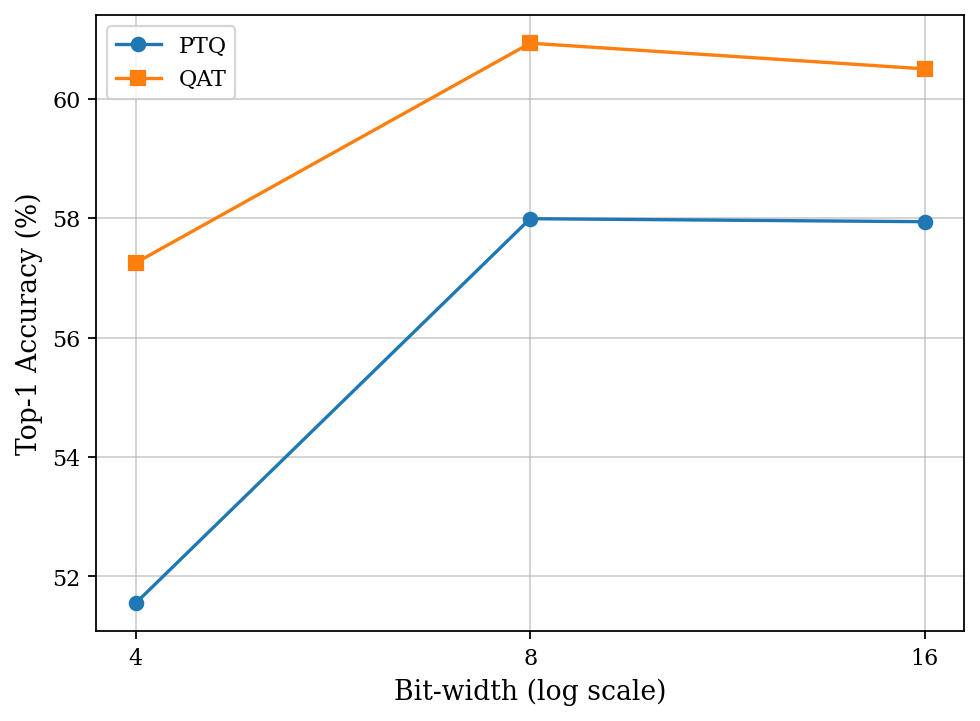

In [57]:
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 160,
})



bits_ptq = np.array([16, 8, 4])
acc_ptq = np.array([(57.96+57.92)/2, 57.99, 51.55])

bits_qat = np.array([16, 8, 4])
acc_qat = np.array([60.50, 60.93, 57.25])

plt.figure(figsize=(7,5))
plt.plot(bits_ptq, acc_ptq, 'o-', label='PTQ')
plt.plot(bits_qat, acc_qat, 's-', label='QAT')
plt.xscale('log', base=2)
plt.xticks(bits_ptq, bits_ptq)
plt.xlabel("Bit-width (log scale)")
plt.ylabel("Top-1 Accuracy (%)")
plt.grid(True, alpha=0.6)
plt.legend()
plt.savefig("Scaling Law: Accuracy vs Bit Precision (VGG11 on CIFAR-100)",dpi = 300)
plt.show()

### Mixed-Precision Quantization Analysis

In [51]:
#  utility functions

def theoretical_size_from_layer_bitmap(model: nn.Module, layer_bit_map: dict):
    
    total_bits = 0
    for name, param in model.named_parameters():
        assigned_bits = None
        if name in layer_bit_map:
            assigned_bits = layer_bit_map[name]
        else:

            for key in layer_bit_map:
                if name.startswith(key):
                    assigned_bits = layer_bit_map[key]
                    break
        if assigned_bits is None:
            assigned_bits = 32
        total_bits += param.numel() * assigned_bits
    return round(total_bits / 8 / 1e6, 2)  # MB

def quantize_tensor_to_nbits(tensor: torch.Tensor, nbits: int):
    if tensor is None:
        return None
    if nbits >= 32:
        return tensor.detach().clone()
    # signed range
    qmax = 2 ** (nbits - 1) - 1
    qmin = -2 ** (nbits - 1)
    max_abs = tensor.abs().max()
    if max_abs == 0:
        return tensor.detach().clone()
    scale = max_abs / qmax
    q = torch.clamp((tensor / scale).round(), qmin, qmax)
    return (q * scale).to(torch.float32)

def apply_per_layer_weight_quant(model: nn.Module, layer_bit_map: dict, copy_model=True, device=None):
    if copy_model:
        model = copy.deepcopy(model)
    orig_device = next(model.parameters()).device
    model = model.cpu()
    with torch.no_grad():
        for name, param in model.named_parameters():    
            assigned_bits = None
            if name in layer_bit_map:
                assigned_bits = layer_bit_map[name]
            else:
                for key in layer_bit_map:
                    if name.startswith(key):
                        assigned_bits = layer_bit_map[key]
                        break
            if assigned_bits is None:
                assigned_bits = 32
            if assigned_bits < 32:
                qparam = quantize_tensor_to_nbits(param.data, assigned_bits)
                param.copy_(qparam)
    if device is not None:
        model = model.to(device)
    else:
        model = model.to(orig_device)
    return model

#  activation variances (calibration)
def collect_activation_variances(model: nn.Module, loader, device, max_batches=50):
    
    model = model.eval().to(device)
    activ_vars = {}
    handles = []
    for n, m in model.named_modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            activ_vars[n] = []
            def makhook(name):
                def hook(module, inp, outp):
                    v = outp.detach().float().view(outp.size(0), -1).var(dim=1).mean().item()
                    activ_vars[name].append(v)
                return hook
            handles.append(m.register_forward_hook(makhook(n)))
    with torch.no_grad():
        count = 0
        for x,y in loader:
            x = x.to(device)
            _ = model(x)
            count += 1
            if count >= max_batches:
                break
    for h in handles:
        h.remove()
    module_var_map = {k: (np.mean(v) if len(v)>0 else 0.0) for k,v in activ_vars.items()}
    return module_var_map

#  layer-bit assignment 
def build_uniform_bit_map(model, bits):
    layer_map = {}
    for name, _ in model.named_parameters():
        layer_map[name] = bits
    return layer_map

def build_simple_mixed_map(model, high_bits=16, low_bits=4):

    layer_map = {}
    first_conv_name = None
    last_linear_name = None
    for n,m in model.named_modules():
        if isinstance(m, nn.Conv2d):
            first_conv_name = n
            break
    linear_modules = [(n,m) for n,m in model.named_modules() if isinstance(m, nn.Linear)]
    if linear_modules:
        last_linear_name = linear_modules[-1][0]  # module name
    for pname, _ in model.named_parameters():
        assigned = low_bits
        if first_conv_name and pname.startswith(first_conv_name):
            assigned = high_bits
        if last_linear_name and pname.startswith(last_linear_name):
            assigned = high_bits
        layer_map[pname] = assigned
    return layer_map

def build_adaptive_mixed_map(model, module_var_map, high_bits=16, mid_bits=8, low_bits=4, top_k=None):
    
    items = sorted(module_var_map.items(), key=lambda x: x[1], reverse=True)
    mnames = [n for n,_ in items]
    nmods = len(mnames)
    if nmods == 0:
        layer_map = {}
        for pname,_ in model.named_parameters():
            layer_map[pname] = mid_bits
        return layer_map
    if top_k is None:
        top_k = max(1, int(0.2 * nmods))   
    mid_k = max(1, int(0.3 * nmods))      
    high_set = set(mnames[:top_k])
    mid_set = set(mnames[top_k: top_k + mid_k])
    low_set = set(mnames[top_k + mid_k:])
    layer_map = {}
    for pname,_ in model.named_parameters():
        assigned = low_bits
        for modname in high_set:
            if pname.startswith(modname):
                assigned = high_bits
                break
        else:
            for modname in mid_set:
                if pname.startswith(modname):
                    assigned = mid_bits
                    break
        layer_map[pname] = assigned
    return layer_map


def eval_mixed_precision_config(base_model, config_name, layer_bit_map, device, testloader, latency_runs=40):
    
    model_q = apply_per_layer_weight_quant(base_model, layer_bit_map, copy_model=True, device=device)
    acc = evaluate(model_q.eval(), testloader, device)
    size_mb = theoretical_size_from_layer_bitmap(base_model, layer_bit_map)
    lat_s = measure_latency(model_q.eval(), device, input_shape=(1,3,32,32), runs=latency_runs, warmup=10)
    latency_ms = lat_s * 1000.0
    return {'config': config_name, 'acc': acc, 'size_MB': size_mb, 'latency_ms': latency_ms}


In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


base = make_vgg11()
base.load_state_dict(torch.load("vgg11_fp32.pth", map_location='cpu'))  
base = base.to(device)
calib_loader = trainloader

print("Collecting activation variances (calibration)...")
module_var_map = collect_activation_variances(base, calib_loader, device, max_batches=50)

top_sorted = sorted(module_var_map.items(), key=lambda x: x[1], reverse=True)[:12]
print("Top sensitive modules (by activation variance):")
for n,v in top_sorted:
    print(f"  {n} -> {v:.6f}")

#  layer bitmaps
uniform_int8_map = build_uniform_bit_map(base, bits=8)
uniform_int4_map = build_uniform_bit_map(base, bits=4)

simple_mixed_map_int4 = build_simple_mixed_map(base, high_bits=16, low_bits=4)  #  first & last 16-bit
simple_mixed_map_int8 = build_simple_mixed_map(base, high_bits=16, low_bits=8)  #  first & last 16-bit; rest 8-bit

adaptive_map = build_adaptive_mixed_map(base, module_var_map, high_bits=16, mid_bits=8, low_bits=4)

Device: cuda
Top sensitive modules (by activation variance):
  classifier.6 -> 14.746112
  features.8 -> 9.076994
  features.3 -> 7.584103
  features.6 -> 7.199423
  features.11 -> 4.256869
  features.13 -> 1.813234
  features.0 -> 1.237420
  features.16 -> 0.426012
  classifier.0 -> 0.283935
  classifier.3 -> 0.218247
  features.18 -> 0.055608


In [45]:
# Evaluation
results_mixed = []
# uniform baseline (int8 & int4)
results_mixed.append(eval_mixed_precision_config(base, "uniform_int8", uniform_int8_map, device, testloader))
results_mixed.append(eval_mixed_precision_config(base, "uniform_int4", uniform_int4_map, device, testloader))
# simple mixed
results_mixed.append(eval_mixed_precision_config(base, "simple_mixed_int4_keep_ends16", simple_mixed_map_int4, device, testloader))
results_mixed.append(eval_mixed_precision_config(base, "simple_mixed_int8_keep_ends16", simple_mixed_map_int8, device, testloader))
# adaptive mixed
results_mixed.append(eval_mixed_precision_config(base, "adaptive_mixed_16/8/4", adaptive_map, device, testloader))

df_mixed = pd.DataFrame(results_mixed)
display(df_mixed)

,config,acc,size_MB,latency_ms
0,uniform_int8,57.93,129.18,3.299451
1,uniform_int4,51.35,64.59,3.259104
2,simple_mixed_int4_keep_ends16,53.45,65.21,3.302646
3,simple_mixed_int8_keep_ends16,58.06,129.59,3.312939
4,adaptive_mixed_16/8/4,55.94,66.86,3.285801


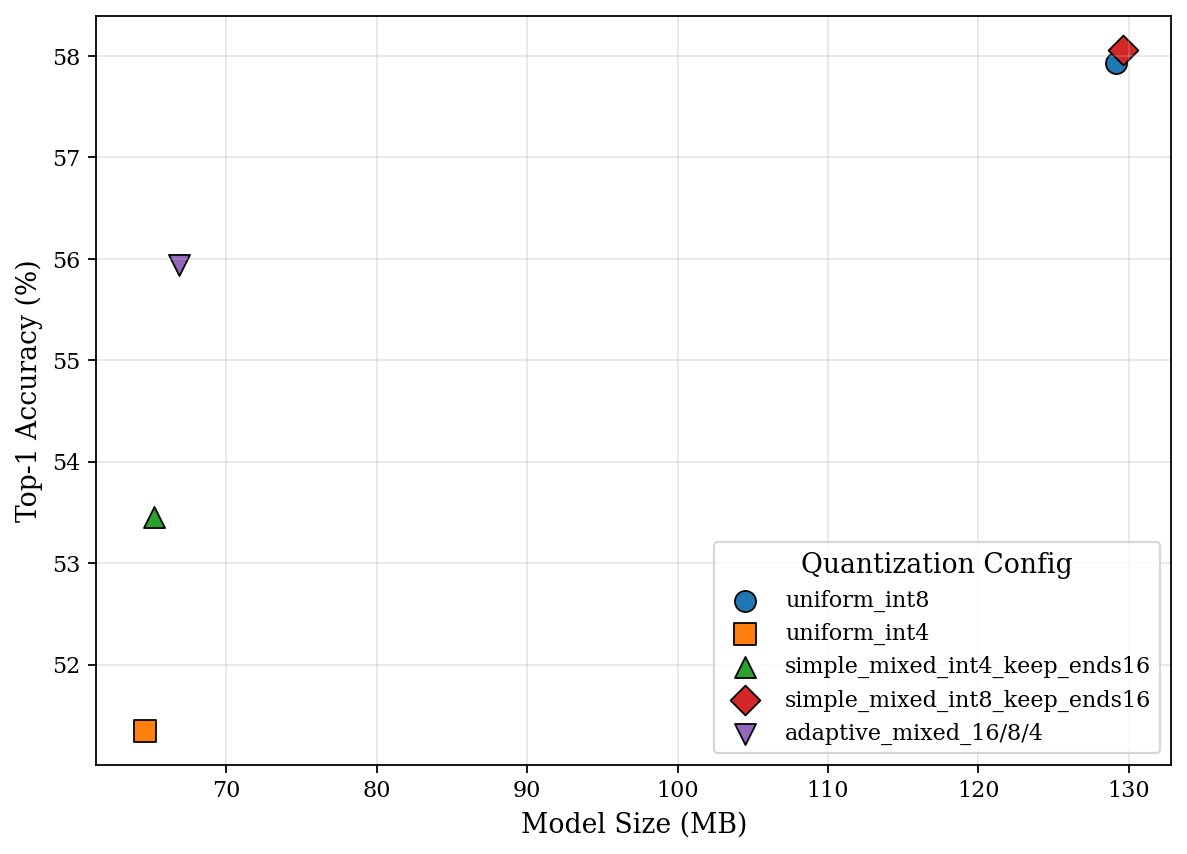

In [59]:
configs = [
    'uniform_int8',
    'uniform_int4',
    'simple_mixed_int4_keep_ends16',
    'simple_mixed_int8_keep_ends16',
    'adaptive_mixed_16/8/4'
]
acc = [57.93, 51.35, 53.45, 58.06, 55.94]
size = [129.18, 64.59, 65.21, 129.59, 66.86]

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
markers = ['o', 's', '^', 'D', 'v']

plt.figure(figsize=(8, 6))

for cfg, a, s, c, m in zip(configs, acc, size, colors, markers):
    plt.scatter(s, a, label=cfg, color=c, marker=m, s=90, edgecolor='k', linewidth=0.8)


plt.xlabel("Model Size (MB)")
plt.ylabel("Top-1 Accuracy (%)")
plt.grid(alpha=0.3)


plt.legend(title="Quantization Config", loc='lower right', frameon=True)

plt.tight_layout()
plt.subplots_adjust(left=0.12, right=0.96, top=0.9, bottom=0.12)
plt.savefig("mixed_precision_accuracy_vs_size_legend.png", dpi=300, bbox_inches='tight')
plt.show()

### Effect of Outliers on Quantization Performance

In [68]:
# activations for chosen layers 
def register_activation_hooks(model, layers_of_interest=None):
    activ_store = defaultdict(list)
    hooks = []
    for name, module in model.named_modules():
        if layers_of_interest is None:
            if not isinstance(module, (nn.Conv2d, nn.Linear)):
                continue
        else:
            if name not in layers_of_interest:
                continue
        # forward hook
        def make_hook(n):
            def hook(m, inp, outp): 
                t = outp.detach().cpu()
                sample_max = t.view(t.size(0), -1).abs().max(dim=1).values.numpy()
                flat = t.view(-1).numpy()
                if flat.size > 200000:
                    flat = np.random.choice(flat, size=200000, replace=False)
                activ_store[n].append({'flat': flat, 'sample_max': sample_max})
            return hook
        hooks.append(module.register_forward_hook(make_hook(name)))
    return activ_store, hooks

def collect_activations_for_layers(model, loader, device, max_batches=40, layers_of_interest=None):
    model = model.eval().to(device)
    activ_store, hooks = register_activation_hooks(model, layers_of_interest=layers_of_interest)
    with torch.no_grad():
        cnt = 0
        for x,y in loader:
            _ = model(x.to(device))
            cnt += 1
            if cnt >= max_batches:
                break
    for h in hooks: h.remove()
    # aggregate into arrays
    aggregated = {}
    for k, vlist in activ_store.items():
        flats = np.concatenate([v['flat'] for v in vlist]) if len(vlist)>0 else np.array([])
        sample_max = np.concatenate([v['sample_max'] for v in vlist]) if len(vlist)>0 else np.array([])
        aggregated[k] = {'flat': flats, 'sample_max': sample_max}
    return aggregated

# For plotting 
def plot_histograms_and_boxplots(aggregated, outdir="outlier_plots", top_k_channels=5):
    os.makedirs(outdir, exist_ok=True)
    summary = []
    for layer, data in aggregated.items():
        flats = data['flat']
        sample_max = data['sample_max']
        if flats.size == 0:
            continue
        q = np.percentile(flats, [50, 99, 99.9, 99.99, 100])
        stats = {
            'layer': layer,
            'median': np.median(flats),
            'p99': q[1],
            'p99.9': q[2],
            'p99.99': q[3],
            'max': q[4],
            'sample_max_mean': sample_max.mean() if sample_max.size>0 else np.nan
        }
        summary.append(stats)

        # histogram 
        plt.figure(figsize=(6,3))
        sns.histplot(flats, bins=200, stat='count', log_scale=(False, True))
        plt.xlim(np.quantile(flats, 0.001), np.quantile(flats, 0.999)) 
        plt.title(f"Histogram (layer={layer})")
        plt.xlabel("activation value")
        plt.ylabel("log count")
        fname = os.path.join(outdir, f"hist_{layer.replace('.', '_')}.png")
        plt.tight_layout(); plt.savefig(fname, dpi=200); plt.close()

        # boxplot: visual of outliers
        plt.figure(figsize=(6,2))
        plt.boxplot(flats, vert=False, showfliers=True)
        plt.title(f"Boxplot (layer={layer})")
        fname = os.path.join(outdir, f"box_{layer.replace('.', '_')}.png")
        plt.tight_layout(); plt.savefig(fname, dpi=200); plt.close()

    df_sum = pd.DataFrame(summary).sort_values('p99.9', ascending=False)
    df_sum.to_csv(os.path.join(outdir, "activation_outlier_summary.csv"), index=False)
    return df_sum

#  Clipping + quantization 
def clip_tensor_at_percentile(tensor: torch.Tensor, lower_p=0.0, upper_p=99.9):
    abs_vals = tensor.detach().abs().view(-1)
    device = abs_vals.device
    q = torch.tensor(upper_p / 100.0, device=device)
    u = torch.quantile(abs_vals, q).item()
    return torch.clamp(tensor, min=-u, max=u), u

def quantize_tensor_symmetric(tensor: torch.Tensor, nbits:int):
    if nbits >= 32:
        return tensor.detach().clone()
    qmax = 2**(nbits-1) - 1
    max_abs = tensor.abs().max().item()
    if max_abs == 0:
        return tensor.detach().clone()
    scale = max_abs / qmax
    q = torch.round(tensor / scale).clamp(-qmax, qmax)
    return (q * scale).to(torch.float32)

def forward_with_activation_clipping_and_quant(model, x, activation_clip_map=None, nbits_activation_map=None, device=None):

    modules = []
    for name, module in model.named_modules():
        if name == '':
            continue
        modules.append((name, module))
    activ_transforms = {}
    if activation_clip_map is None and nbits_activation_map is None:
        return model(x)

    handles = []
    outputs_cache = {}

    def make_hook(name):
        def hook(module, inp, out):
            t = out.detach()
            if activation_clip_map and name in activation_clip_map and activation_clip_map[name] is not None:
                upper_p = activation_clip_map[name]
                t, u = clip_tensor_at_percentile(t, upper_p=upper_p)
            if nbits_activation_map and name in nbits_activation_map and nbits_activation_map[name] is not None:
                nbits = nbits_activation_map[name]
                t = quantize_tensor_symmetric(t, nbits)
            return t 
        return hook
    orig_forwards = {}
    def wrap_module_forward(module, name):
        orig = module.forward
        orig_forwards[name] = orig
        def new_forward(*inputs, _mod=module, _name=name):
            out = orig(*inputs)
            if activation_clip_map and _name in activation_clip_map and activation_clip_map[_name] is not None:
                out, _ = clip_tensor_at_percentile(out, upper_p=activation_clip_map[_name])
            if nbits_activation_map and _name in nbits_activation_map and nbits_activation_map[_name] is not None:
                out = quantize_tensor_symmetric(out, nbits_activation_map[_name])
            return out
        module.forward = new_forward
    for name, module in model.named_modules():
        if name == '':
            continue
        if (activation_clip_map and name in activation_clip_map) or (nbits_activation_map and name in nbits_activation_map):
            wrap_module_forward(module, name)

    # forward pass
    out = model(x.to(device))
    #  original forwards
    for name, module in model.named_modules():
        if name == '':
            continue
        if name in orig_forwards:
            module.forward = orig_forwards[name]
    return out

# Evaluating clipped vs unclipped quantization  

def eval_outlier_strategies(model_fp32, testloader, device,
                            weight_bits_list=[8,4],
                            activation_bits_list=[8,4],
                            clip_percentiles=[None, 99.9, 99.0],
                            layers_to_clip=None,
                            max_calib_batches=40):
    model_fp32 = model_fp32.eval().to(device)
    module_names = [n for n,m in model_fp32.named_modules() if isinstance(m, (nn.Conv2d, nn.Linear))]
    if layers_to_clip is None:
        layers_to_clip = module_names

    aggregated = collect_activations_for_layers(model_fp32, trainloader, device, max_batches=max_calib_batches,
                                                layers_of_interest=layers_to_clip)
    outdir = "outlier_analysis_plots"
    os.makedirs(outdir, exist_ok=True)
    df_summary = plot_histograms_and_boxplots(aggregated, outdir=outdir)
    print("Saved activation histograms and boxplots to:", outdir)
    print(df_summary.head(20))

    results = []
    for weight_bits in weight_bits_list:
        model_wq = copy.deepcopy(model_fp32).cpu()
        with torch.no_grad():
            for name, p in model_wq.named_parameters():
                p.data = quantize_tensor_symmetric(p.data, weight_bits)
        model_wq = model_wq.to(device)

        for activation_bits in activation_bits_list:
            for clip_p in clip_percentiles:
                if clip_p is None:
                    activation_clip_map = {}
                else:
                    activation_clip_map = {ln: clip_p for ln in layers_to_clip}

                # activation bits map
                if activation_bits is None:
                    activation_bits_map = {}
                else:
                    activation_bits_map = {ln: activation_bits for ln in module_names}

                model_test = copy.deepcopy(model_wq).to(device)

                orig_forwards = {}
                for name, module in model_test.named_modules():
                    if name == '':
                        continue
                    needs_clip = (clip_p is not None and name in activation_clip_map)
                    needs_act_q = (activation_bits is not None and name in activation_bits_map)
                    if needs_clip or needs_act_q:
                        # wrap
                        orig_forwards[name] = module.forward
                        def make_new_forward(orig_forward, nm=name):
                            def new_forward(*inputs, _orig=orig_forward, _nm=nm):
                                out = _orig(*inputs)
                                if clip_p is not None and _nm in activation_clip_map:
                                    out, _u = clip_tensor_at_percentile(out, upper_p=activation_clip_map[_nm])
                                if activation_bits is not None and _nm in activation_bits_map:
                                    out = quantize_tensor_symmetric(out, activation_bits_map[_nm])
                                return out
                            return new_forward
                        module.forward = make_new_forward(orig_forwards[name])

                #  accuracy
                acc = evaluate(model_test.eval(), testloader, device)
                lat_s = measure_latency(model_test.eval(), device, input_shape=(1,3,32,32), runs=40, warmup=10)
                latency_ms = lat_s*1000.0
                #  theoretical size (weights bits)
                total_param_bits = sum([p.numel() * (weight_bits if p.requires_grad else 0) for _,p in model_test.named_parameters()])
                size_mb = round(total_param_bits/8/1e6, 2)

                results.append({
                    'weight_bits': weight_bits,
                    'activation_bits': activation_bits,
                    'clip_percentile': clip_p,
                    'acc': acc,
                    'size_MB': size_mb,
                    'latency_ms': latency_ms
                })

                # restore original forwards
                for name, module in model_test.named_modules():
                    if name == '':
                        continue
                    if name in orig_forwards:
                        module.forward = orig_forwards[name]

    df_results = pd.DataFrame(results)
    df_results.to_csv(os.path.join(outdir, "outlier_quantization_results.csv"), index=False)
    print("Saved results to", os.path.join(outdir, "outlier_quantization_results.csv"))
    return df_summary, df_results


In [67]:
base = make_vgg11()
base.load_state_dict(torch.load("vgg11_fp32.pth", map_location='cpu'))
base = base.to(device)

#  layers to inspect (first conv, some mid convs, last linear)
print("Listing conv/linear names for reference:")
for n,m in base.named_modules():
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        print(n)

layers_to_check = [n for n,m in base.named_modules() if isinstance(m,(nn.Conv2d, nn.Linear))]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Listing conv/linear names for reference:
features.0
features.3
features.6
features.8
features.11
features.13
features.16
features.18
classifier.0
classifier.3
classifier.6


In [70]:
df_activation_summary, df_outlier_results = eval_outlier_strategies(base, testloader, device,
                                                                   weight_bits_list=[8,4],
                                                                   activation_bits_list=[8,4],
                                                                   clip_percentiles=[None, 99.9, 99.0],
                                                                   layers_to_clip=layers_to_check,
                                                                   max_calib_batches=40)


Saved activation histograms and boxplots to: outlier_analysis_plots
           layer    median        p99      p99.9     p99.99        max  \
10  classifier.6 -0.372572  12.096762  23.667681  38.206073  72.851143   
2     features.6 -1.277741   4.373380   7.607188  10.993173  22.185856   
1     features.3 -1.149658   3.575301   7.270128  11.411595  22.195580   
3     features.8 -3.128521   3.314237   7.153647  11.612505  34.714985   
0     features.0 -0.134527   2.943429   6.290186   9.732332  16.599585   
4    features.11 -1.569248   2.894874   5.664051   8.844286  26.400465   
5    features.13 -1.401295   1.353909   3.183414   5.479364  16.490149   
8   classifier.0 -0.086689   1.395446   2.612689   4.322984   9.466601   
9   classifier.3 -0.018829   1.409778   2.450700   3.934166   9.077868   
6    features.16 -0.482666   1.034738   2.087485   3.431451   7.643468   
7    features.18 -0.203858   0.427696   1.076593   1.958147   6.293141   

    sample_max_mean  
10        14.705719  

In [71]:
print("\nActivation outlier summary (top rows):")
display(df_activation_summary.head(12))


Activation outlier summary (top rows):


,layer,median,p99,p99.9,p99.99,max,sample_max_mean
10,classifier.6,-0.372572,12.096762,23.667681,38.206073,72.851143,14.705719
2,features.6,-1.277741,4.373380,7.607188,10.993173,22.185856,17.144556
1,features.3,-1.149658,3.575301,7.270128,11.411595,22.195580,22.355690
3,features.8,-3.128521,3.314237,7.153647,11.612505,34.714985,17.769491
0,features.0,-0.134527,2.943429,6.290186,9.732332,16.599585,9.758298
4,features.11,-1.569248,2.894874,5.664051,8.844286,26.400465,11.373636
5,features.13,-1.401295,1.353909,3.183414,5.479364,16.490149,7.729440
8,classifier.0,-0.086689,1.395446,2.612689,4.322984,9.466601,2.032837
9,classifier.3,-0.018829,1.409778,2.450700,3.934166,9.077868,1.904512
6,features.16,-0.482666,1.034738,2.087485,3.431451,7.643468,2.702120


In [72]:
print("\nQuantization results (combinations):")
display(df_outlier_results.sort_values(['weight_bits','activation_bits','clip_percentile']))


Quantization results (combinations):


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,weight_bits,activation_bits,clip_percentile,acc,size_MB,latency_ms
11,4,4,99.0,38.81,64.59,9.656298
10,4,4,99.9,45.06,64.59,9.169161
9,4,4,NaN,26.76,64.59,5.348599
8,4,8,99.0,44.19,64.59,9.027106
7,4,8,99.9,51.32,64.59,8.968568
6,4,8,NaN,51.35,64.59,5.269039
5,8,4,99.0,44.18,129.18,9.100693
4,8,4,99.9,51.17,129.18,9.016830
3,8,4,NaN,29.58,129.18,5.373150
2,8,8,99.0,50.17,129.18,8.992207


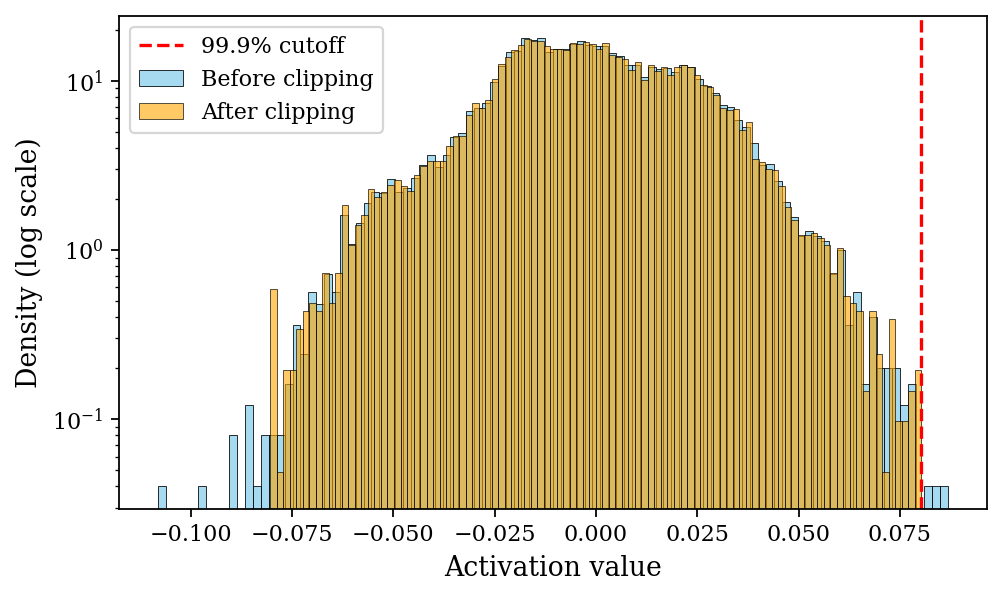

In [87]:
# visualization

layer_name = "classifier.6"
activation_cache = {}

def get_activation(name):
    def hook(model, input, output):
        activation_cache[name] = output.detach()
    return hook

layer = dict(baseline.named_modules())[layer_name]
hook_handle = layer.register_forward_hook(get_activation(layer_name))

baseline.eval()
with torch.no_grad():
    for images, _ in testloader:
        images = images.to(device)
        _ = baseline(images)
        break  
hook_handle.remove()


acts = activation_cache[layer_name].flatten().cpu().numpy()
clip_percentile = 99.9
clip_val = np.percentile(np.abs(acts), clip_percentile)

acts_clipped = np.clip(acts, -clip_val, clip_val)

#  both distributions
plt.figure(figsize=(7,4))
sns.histplot(acts, bins=100, color='skyblue', label='Before clipping', stat='density')
sns.histplot(acts_clipped, bins=100, color='orange', label='After clipping', stat='density', alpha=0.6)
plt.axvline(clip_val, color='r', ls='--', label=f'{clip_percentile}% cutoff')
plt.yscale('log')
plt.xlabel('Activation value')
plt.ylabel('Density (log scale)')
plt.legend()
plt.savefig("Before vs After Clipping",dpi= 300)
plt.show()

**Impact of Clipping on Quantization Accuracy**

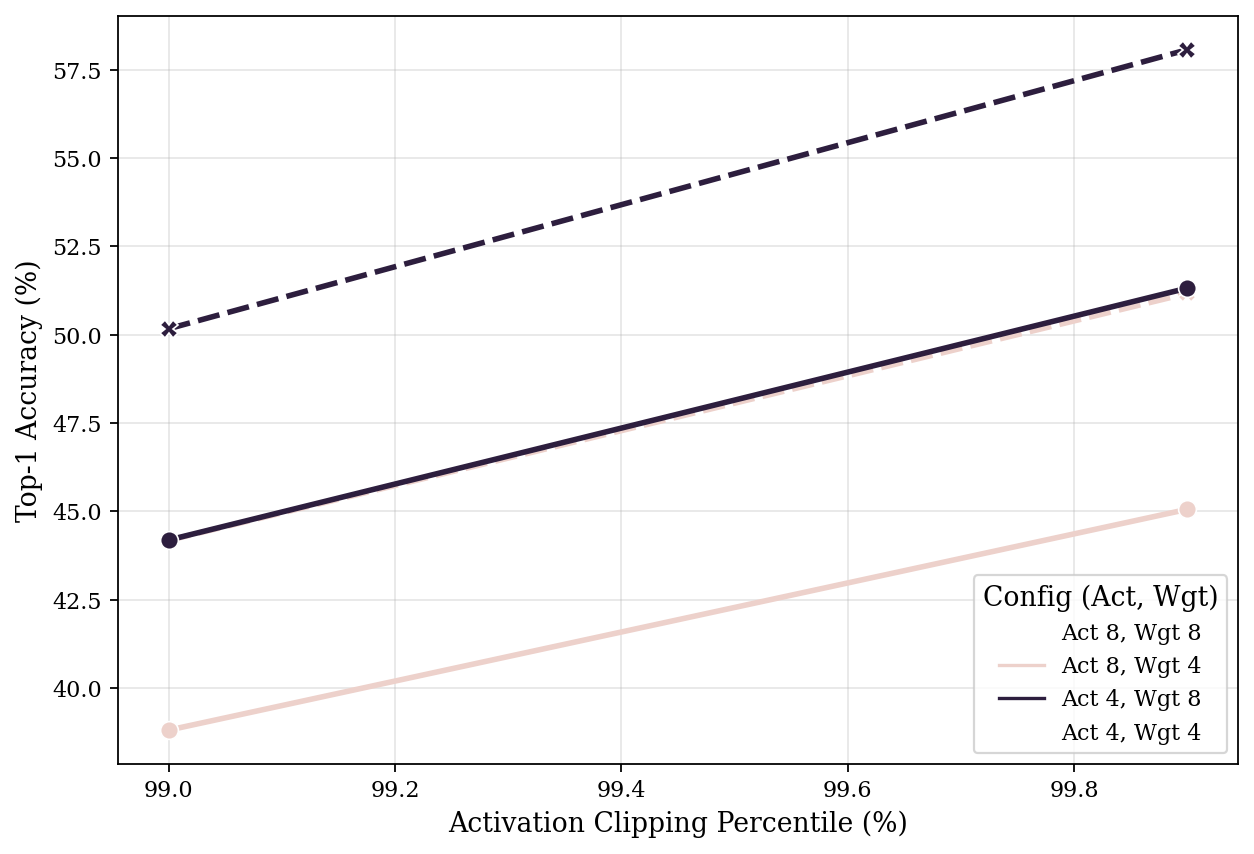

In [89]:
plt.figure(figsize=(8, 5.5))
sns.lineplot(
    data=df_outlier_results,
    x='clip_percentile',
    y='acc',
    hue='activation_bits',
    style='weight_bits',
    markers=True,
    linewidth=2.5,
    markersize=8
)

handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [
    'Act 8, Wgt 8',
    'Act 8, Wgt 4',
    'Act 4, Wgt 8',
    'Act 4, Wgt 4'
]
plt.legend(handles, new_labels, title='Config (Act, Wgt)', loc='lower right')

plt.xlabel("Activation Clipping Percentile (%)")
plt.ylabel("Top-1 Accuracy (%)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("outlier_clipping_accuracy.png", dpi=300, bbox_inches='tight')
plt.show()